In [3]:
import os
import keras
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import src.features.build_features as build_features
from src.models.train_model import MonteCarloDropout, MCLSTM

# Load the Models

In [11]:
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"

merged_model = keras.models.load_model(os.path.join(load_path, "merged-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

FNN_model = keras.models.load_model(os.path.join(load_path, "FNN-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

RNN_model = keras.models.load_model(os.path.join(load_path, "RNN-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

# merged_model_mc = keras.models.load_model(os.path.join(load_path, "merged-ce-mc.h5"), 
#                                        custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

# FNN_model_mc = keras.models.load_model(os.path.join(load_path, "FNN-ce-mc.h5"), 
#                                        custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

# RNN_model_mc = keras.models.load_model(os.path.join(load_path, "RNN-ce-mc.h5"), 
#                                        custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

# Load Test Data

In [5]:
data = build_features.load_preprocessed_data(use_all_data=True)

In [12]:
test_size = 1_000

event_X_train, event_X_test = build_features.scale_event_data(data['event_X_train'], data['event_X_test'])
object_X_train, object_X_test = build_features.scale_object_data(data['object_X_train'], data['object_X_test'])
y_train, y_test = data['y_train'], data['y_test']

sample_event_X_test = event_X_test.iloc[:test_size]
sample_object_X_test = object_X_test[:test_size]
sample_y_test = data['y_test'].iloc[:test_size]

models = [(merged_model, [event_X_test, object_X_test], 'Merged Model'), (RNN_model, object_X_test, 'RNN Model'), (FNN_model, event_X_test, 'FNN Model')]
# mc_models = [(merged_model_mc, [sample_event_X_test, sample_object_X_test], 'Merged Model'), (FNN_model_mc, sample_event_X_test, 'FNN Model'), (RNN_model_mc, sample_object_X_test, 'RNN Model')]

# Make Predictions

In [5]:
# Goes through each model and gets the mean prediction of n_samples predictions of the test set, then repeats n_preds times

# n_preds = 10 # number of times to predict the test set
# n_samples = 100 # number of models to sample from
# auc_dicts = []

# def mc_predict(X, model, n_models):
#     preds = [model.predict(X).ravel() for _ in range(n_models)]
#     return np.mean(preds, axis=0)

# for model, X_test, model_name in tqdm(mc_models):
#     for i in tqdm(range(n_preds)):
#         preds = mc_predict(X_test, model, n_samples)
#         auc_score = roc_auc_score(sample_y_test, preds)
#         auc_dicts.append({'model': model_name, 'ROC AUC': auc_score})

# auc_df = pd.DataFrame.from_records(auc_dicts)

In [6]:
# baseline_preds_merged = merged_model.predict([sample_event_X_test, sample_object_X_test])
# baseline_auc_merged = roc_auc_score(sample_y_test, baseline_preds_merged)

# baseline_preds_fnn = FNN_model.predict(sample_event_X_test)
# baseline_auc_fnn = roc_auc_score(sample_y_test, baseline_preds_fnn)

# baseline_preds_rnn = RNN_model.predict(sample_object_X_test)
# baseline_auc_rnn = roc_auc_score(sample_y_test, baseline_preds_rnn)

# with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']):
#     plt.figure(figsize=(7, 7))
#     sns.boxplot(x="model", y="ROC AUC", data=auc_df)
#     plt.axhline(y=baseline_auc_merged, color='r', linestyle='-')
#     plt.axhline(y=baseline_auc_fnn, color='g', linestyle='-')
#     plt.axhline(y=baseline_auc_rnn, color='b', linestyle='-')
#     plt.show()

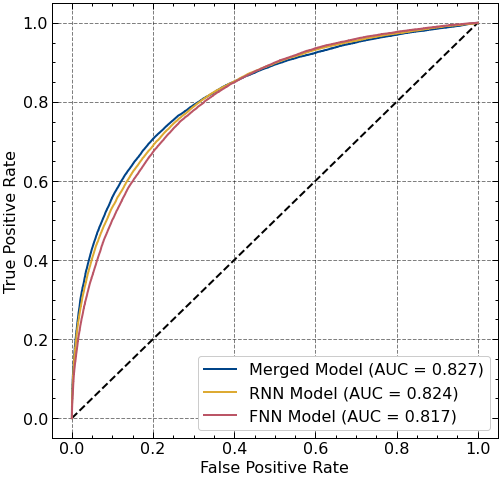

In [13]:
from sklearn.metrics import roc_curve

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']) as style:
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], "k--")
    #plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    for model, X_test, model_name in models:
        preds = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, preds)
        auc_score = roc_auc_score(y_test, preds)
        label = f"{model_name} (AUC = {auc_score:.3f})"
        plt.plot(fpr, tpr, label=label)

    plt.legend()
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

Merged Model best threshold: 0.959 best significance: 9.941
RNN Model best threshold: 0.898 best significance: 8.929
FNN Model best threshold: 0.857 best significance: 7.478


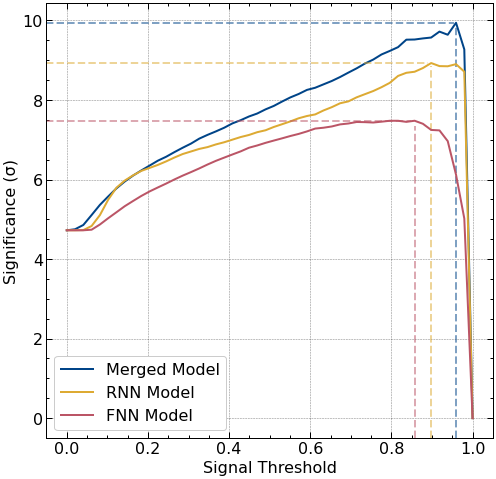

In [14]:
config = yaml.safe_load(open(r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\src\config.yaml"))

X_test = data["X_test"]
test_weight = X_test["xs_weight"].values
test_frac = len(y_test) / len(y_train)

n_thresholds = 50
thresholds = np.linspace(0, 1, n_thresholds)
significance = np.zeros(len(thresholds), dtype=float)

lum = config["data"]["lum"]
epsilon = 1e-5
labels = y_test.values

with plt.style.context(['science', 'notebook', 'grid', 'high-contrast']) as style:
    plt.figure(figsize=(8, 8))
    for model, X_test, model_name in tqdm(models):
        sg = np.zeros(len(thresholds))
        bg = np.zeros(len(thresholds))
        preds = model.predict(X_test)

        for i, threshold in enumerate(thresholds):
            sg[i] = (
                sum(
                    [
                        test_weight[j]
                        for j, (pred, label) in enumerate(zip(preds, labels))
                        if (pred >= threshold and label == 1)
                    ]
                )
                * lum
                / test_frac
            )
            bg[i] = (
                sum(
                    [
                        test_weight[j]
                        for j, (pred, label) in enumerate(zip(preds, labels))
                        if (pred >= threshold and label == 0)
                    ]
                )
                * lum
                / test_frac
            )

        significance = sg / np.sqrt(bg + epsilon)

        best_index = significance.argmax()
        best_threshold = thresholds[best_index]
        best_significance = significance[best_index]
        print(f"{model_name} best threshold: {best_threshold:.3f} best significance: {best_significance:.3f}")
        
        p = plt.plot(thresholds, significance, label=model_name)
        c = p[-1].get_color()
        x_lim = plt.gca().get_xlim()
        y_lim = plt.gca().get_ylim()
        x_max = best_threshold / x_lim[1]
        y_max = best_significance / y_lim[1]

        plt.axvline(x=best_threshold, ymin=0, ymax=y_max, linestyle='--', c=c, alpha=0.5)
        plt.axhline(y=best_significance, xmin=0, xmax=x_max, linestyle='--', c=c, alpha=0.5)

        plt.ylabel("Significance (σ)")
        plt.xlabel("Signal Threshold")

    plt.legend()
    plt.show()

In [23]:
test_size = 1_000

data = build_features.load_preprocessed_data(use_all_data=True)

event_X_train, event_X_test = build_features.scale_event_data(data['event_X_train'], data['event_X_test'])
object_X_train, object_X_test = build_features.scale_object_data(data['object_X_train'], data['object_X_test'])
y_train, y_test = data['y_train'], data['y_test']

# try:
#     data['event_X_train'].drop('MHT_pt', axis=1, inplace=True)
#     data['event_X_test'].drop('MHT_pt', axis=1, inplace=True)
# except KeyError:
#     pass

In [152]:
import shap

n_values = 1000
n_bg = 10

FNN_model_no_met = keras.models.load_model(os.path.join(load_path, "FNN_no_met.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})
merged_model_no_met = keras.models.load_model(os.path.join(load_path, "merged_no_met.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})
merged_model_no_mht = keras.models.load_model(os.path.join(load_path, "merged_no_mht.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

model = merged_model
model_name = 'merged'

if "FNN" in model_name:
    background = [
        data["event_X_train"].head(n_bg).values,
    ]
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(
        data["event_X_test"].head(n_values).values
    )
    shap_values = shap_values[0]
else:
    background = [
        data["event_X_train"].head(n_bg).values,
        data["object_X_train"][:n_bg],
    ]
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(
        [
            data["event_X_test"].head(n_values).values,
            data["object_X_test"][:n_values],
        ]
    )

# shap_df = pd.DataFrame(shap_values, columns=event_X_test.columns)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [68]:
import yaml

config = yaml.safe_load(open(r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\src\config.yaml"))

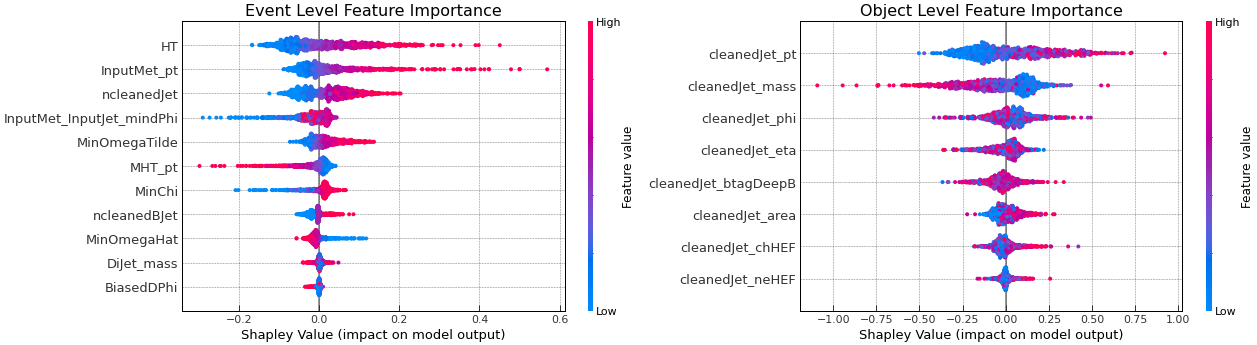

In [176]:
def make_summary_plot(shap_values, n_values, data):
    with plt.style.context(['science', 'notebook', 'grid', 'high-contrast']):
        shap_condensed = np.sum(shap_values[0][1], axis=1)
        shap_object_features = np.sum(data["object_X_test"][:n_values], axis=1)

        plt.subplot(1,2,1)

        shap.summary_plot(
            shap_values[0][0],
            features=data["event_X_test"].head(n_values),
            feature_names=data["event_X_test"].columns,
            plot_type='dot',
            show=False,
        )
        plt.minorticks_off()
        plt.xlabel('Shapley Value (impact on model output)')
        plt.title('Event Level Feature Importance')

        ax = plt.gca()
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['right'].set_visible(True)

        plt.subplot(1,2,2)

        shap.summary_plot(
            shap_condensed, 
            feature_names=config['data']['object_cols'],
            features=shap_object_features,
            show=False)

        plt.xlabel('Shapley Value (impact on model output)')
        plt.title('Object Level Feature Importance')
        
        ax = plt.gca()
        ax.figure.set_size_inches(18, 5)

        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['right'].set_visible(True)

        plt.minorticks_off()
        plt.tight_layout()
        plt.show()

make_summary_plot(shap_values, n_values, data)

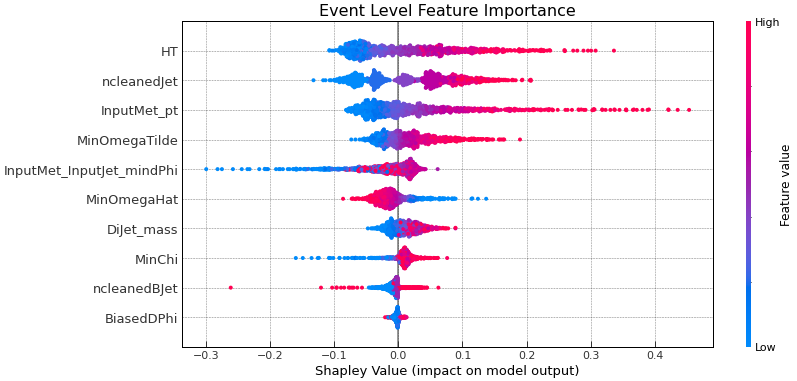

In [21]:
def make_summary_plot(shap_values, n_values, data):
    with plt.style.context(['science', 'notebook', 'grid', 'high-contrast']):
        shap.summary_plot(
            shap_values,
            features=data["event_X_test"].head(n_values),
            feature_names=data["event_X_test"].columns,
            plot_type='dot',
            show=False,
        )

        ax = plt.gca()
        fig = plt.gcf()
        fig.set_figwidth(12)

        plt.minorticks_off()

        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['right'].set_visible(True)

        plt.xlabel('Shapley Value (impact on model output)')
        plt.title('Event Level Feature Importance')
        plt.tight_layout()
        plt.show()
        
make_summary_plot(shap_values, n_values, data)